# Определение возраста покупателей по фотографии <a id="title"></a>

**Цель исследования:**
Построить модель, которая по фотографии определит приблизительный возраст человека. MAE модели должно быть не больше 8.

**Ход исследования:**

Основные данные получаем из папки с изображениями ```final_files``` и файла ```labels.csv``` с разметкой изображений.

Исследование пройдет в 5 этапов:

1. Загрузка данных
2. Предобработка и анализ данных
3. Обучение модели для определения возраста по фотографии
4. Анализ качества обученной модели
5. Написание общего вывода


## Исследовательский анализ данных

### Импорт библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
RANDOM_STATE = 42

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим на первые строки датафрейма.

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим на общую информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data['file_name'].duplicated().sum()

0

В датафрейме 7591 строка и два столбца - строковый ```file_name``` и целочисленный ```real_age``` (целевой). Пропусков нет.

Дубликатов по имени файла нет, то есть размер выборки - 7591 изображение. Колонка с именем файла включает в себя расширение файла.

### Анализ данных

Посмотрим на распределение возраста в выборке.

In [6]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

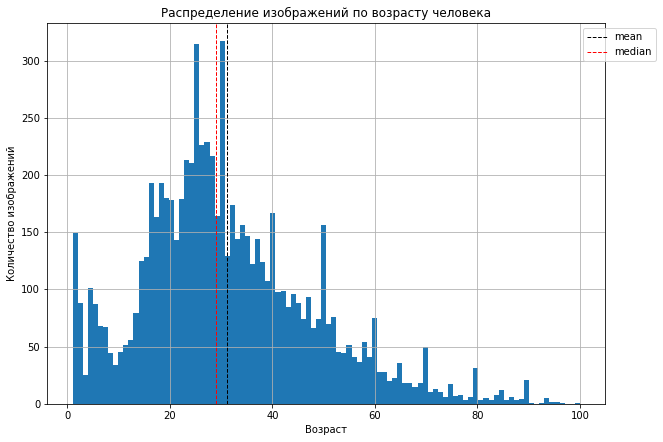

In [7]:
data['real_age'].hist(bins=100, figsize=(10, 7))
plt.axvline(data['real_age'].mean(), color='k', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(data['real_age'].median(), color='r', linestyle='dashed', linewidth=1, label='median')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title('Распределение изображений по возрасту человека')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

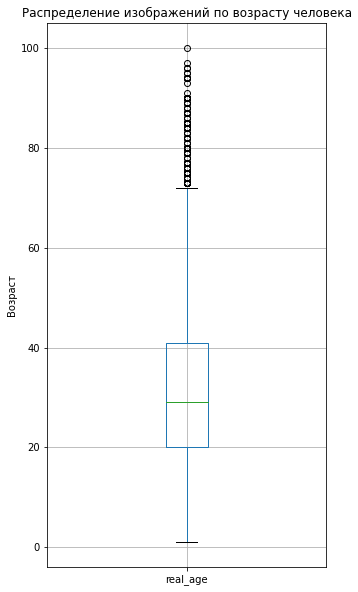

In [8]:
data.boxplot('real_age', figsize=(5, 10))
plt.title('Распределение изображений по возрасту человека')
plt.ylabel('Возраст')
plt.show()

Распределение скошено вправо. Среднее значение возраста - 31, медиана - 29. Минимальное значение - 1, максимальное - 100.

Пик значений приходится на 25-30 лет, людей старше 70 в выборке совсем мало.

Посмотрим на несколько фотографий из датасета.

In [9]:
datagen=ImageDataGenerator(rescale=1./255.)

In [10]:
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    batch_size=16,
    seed=RANDOM_STATE,
    class_mode='raw',
    target_size=(224,224)
)

Found 7591 validated image filenames.


In [11]:
features, target = next(datagen_flow)

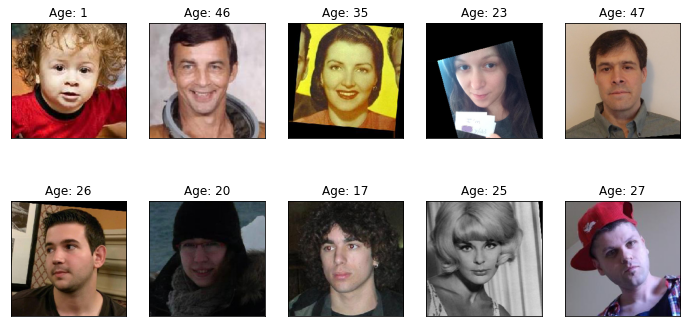

In [12]:
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])

Имеем фотографии разного качества и цветности. Вокруг некоторых фотографий черная рамка, появившаяся при повороте картинок (вероятно, из датасета взяты фотографии с кропами лиц: см. *we also provide a corresponding X.jpg_face.jpg which contains the cropped & rotated face with a 40% margin* в описании датасета).

### Исследовательский анализ данных - итог

Загрузили данные с разметкой возраста людей на фотографиях.

В выборке имеется 7591 изображение, для каждого указано целочисленное значение возраста. 

Распределение возрастов в выборке скошено вправо. Среднее значение возраста - 31, медиана - 29. Минимальное значение - 1, максимальное - 100.
Пик значений приходится на 25-30 лет, людей старше 70 в выборке совсем мало.

Фотографии в выборке разного качества и цветности. На фотографиях кропы лиц с небольшими допусками. Вокруг некоторых фотографий черная рамка, появившаяся при повороте картинок.

## Обучение модели

Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. Будем использовать архитектуру ResNet. В качестве функции потерь возьмем MSE, целевая метрика - MAE.

Код обучения модели:

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    data = pd.read_csv(path + 'labels.csv')
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        subset='training',
        seed=42,
        class_mode='raw',
        target_size=(224,224)
    )
    return datagen_flow
    
    
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    data = pd.read_csv(path + 'labels.csv')
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        subset='validation',
        seed=42,
        class_mode='raw',
        target_size=(224,224)
    )
    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
                validation_data=test_data,
                batch_size=batch_size, epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                verbose=2, shuffle=True)
    return model

```

Вывод модели:

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
...
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 81s - loss: 212.2375 - mae: 10.6372 - val_loss: 820.3262 - val_mae: 23.6774
Epoch 2/10
356/356 - 48s - loss: 71.4319 - mae: 6.4112 - val_loss: 168.7270 - val_mae: 9.4953
Epoch 3/10
356/356 - 48s - loss: 38.2224 - mae: 4.8060 - val_loss: 79.0048 - val_mae: 6.6033
Epoch 4/10
356/356 - 49s - loss: 23.9629 - mae: 3.7889 - val_loss: 73.9030 - val_mae: 6.4784
Epoch 5/10
356/356 - 48s - loss: 18.0858 - mae: 3.2421 - val_loss: 76.8582 - val_mae: 6.7346
Epoch 6/10
356/356 - 48s - loss: 15.3053 - mae: 2.9682 - val_loss: 71.9706 - val_mae: 6.4348
Epoch 7/10
356/356 - 49s - loss: 11.8677 - mae: 2.6037 - val_loss: 67.8367 - val_mae: 6.1153
Epoch 8/10
356/356 - 48s - loss: 10.7833 - mae: 2.4851 - val_loss: 70.1933 - val_mae: 6.3831
Epoch 9/10
356/356 - 48s - loss: 10.2424 - mae: 2.4207 - val_loss: 72.3379 - val_mae: 6.3461
Epoch 10/10
356/356 - 48s - loss: 10.0708 - mae: 2.4034 - val_loss: 77.7134 - val_mae: 6.5751
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 77.7134 - mae: 6.5751

```

## Анализ обученной модели

MAE модели на тестовой выборке - 6.5751. Это удовлетворяет требованию ```MAE ≤ 8```.

MAE = 6.5751 означает, что модель в среднем ошибается на 6.5 лет. Цели заказчика:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Для определения возрастной группы покупателей такого качества модели вполне хватит. 

В контроле добросовестности кассиров модель тоже может помочь - хоть точное определение возраста мы не можем гарантировать, мы можем, например, помечать фотографии всех людей, чей возраст модель определила в районе 25 и ниже, как приоритетные для проверки.

## Общий вывод

Проанализировали данные о возрасте людей на фотографиях, обучили модель, предсказывающую возраст человека по фотографии.

1. В выборке имеется 7591 изображение, для каждого указано целочисленное значение возраста.

    Распределение возрастов в выборке скошено вправо. Среднее значение возраста - 31, медиана - 29. Минимальное значение - 1, максимальное - 100. Пик значений приходится на 25-30 лет, людей старше 70 в выборке совсем мало.

    Фотографии в выборке разного качества и цветности. На фотографиях кропы лиц с небольшими допусками. Вокруг некоторых фотографий черная рамка, появившаяся при повороте картинок.
    
2. Обучили свёрточную нейронную сеть на датасете с фотографиями людей. Использовали архитектуру ResNet с весами ImageNet. Для последнего слоя использовали активацию ReLU, чтобы избежать отрицательных значений возраста в прогнозе. В качестве функции потерь взяли MSE.

3. Обученная на 10 эпохах модель показала на тестовой выборке MAE = 6.5751. Это удовлетворяет требованию ```MAE ≤ 8```.
    
    MAE = 6.5751 означает, что модель в среднем ошибается на 6.5 лет. Цели заказчика:
    + Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    + Контролировать добросовестность кассиров при продаже алкоголя.
    
    Для определения возрастной группы покупателей такого качества модели вполне хватит. 
    
    В контроле добросовестности кассиров модель тоже может помочь - хоть точное определение возраста мы не можем гарантировать, мы можем, например, помечать фотографии всех людей, чей возраст модель определила в районе 25 и ниже, как приоритетные для проверки.


[В начало](#title)